In this tutorial, we want illustrate the unfitted space-time functionality of ngsxfem. To this end, we consider a convection-diffusion problem on a moving domain with a manufactured solution (and according right-hand side source term). To illustrate the setting, the simulation end result from ngsxfem is illustrated in the following video:

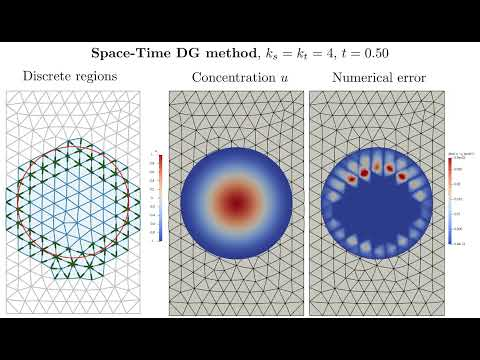

In [18]:
from IPython.display import YouTubeVideo
YouTubeVideo('16emZemDZak', width=900, height=520)

In this tutorial we make use of `ipywidgets`. You can (in the ideal case) simply install them with executing the next cell. You will however need to restart jupyter afterwards.

In [ ]:
!pip3 install --user ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# Unfitted space-time finite elements
In this example we consider a moving domain problem with homogeneous Neumann boundary conditions:

$$
\left\{
\begin{aligned}
\partial_t u + \mathbf{w} \cdot \nabla u - \alpha \Delta u &= f \quad \text{ in } \Omega(t),  & \\
~ \partial_{\mathbf{n}} u &=  0  \quad \text{ on } \partial \Omega(t), & \\
u &= u_0  \quad \text{at } t=0, & \\
\end{aligned}\right.
$$

$$
\operatorname{div}(\mathbf{w}) = 0  \quad \text{ in } \Omega(t),  \quad \mathbf{w} \cdot n = \mathcal{V}_n \text{ on } \partial \Omega(t).
$$

We consider the Discountinuous Galerkin space-time discretization as discussed in [1, 2], which is of high order in space and time.

**Literature:**

[1]: J. Preuß. Higher order unfitted isoparametric space-time FEM on moving domains. Master thesis, University of Göttingen, 2018. https://cpde.math.uni-goettingen.de/data/Pre18_Ma.pdf

[2]: F. Heimann. On Discontinuous- and Continuous-In-Time Unfitted Space-Time Methods for PDEs on Moving Domains. Master thesis, University of Göttingen, 2020. https://cpde.math.uni-goettingen.de/data/Hei20_Ma.pdf

In [ ]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from xfem import *
from math import pi
from xfem.lset_spacetime import *
ngsglobals.msg_level = 1

#import netgen.gui 
DrawDC = MakeDiscontinuousDraw(Draw)

Firstly, we pick some discretisation parameters:

In [ ]:
# DISCRETIZATION PARAMETERS:

# Parameter for refinement study:
i = 3
n_steps = 2**i
space_refs = i

# Polynomial order in time
k_t = 2
# Polynomial order in space
k_s = k_t
# Polynomial order in time for level set approximation
lset_order_time = k_t
# Integration order in time
time_order = 2 * k_t
# Time stepping parameters
tstart = 0
tend = 0.5
delta_t = (tend - tstart) / n_steps
maxh = 0.5
# Ghost-penalty parameter
gamma = 0.05

## Background geometry and mesh:

* We consider a simple square as background domain an use a simple mesh for that.
* The space-time method uses tensor-product elements. Hence, we do not need space-time meshes.

In [ ]:
# Outer domain:
rect = SplineGeometry()
rect.AddRectangle([-0.6, -1], [0.6, 1])
ngmesh = rect.GenerateMesh(maxh=maxh, quad_dominated=False)
for j in range(space_refs):
    ngmesh.Refine()
mesh = Mesh(ngmesh)

## Handling of the time variable

For the handling of the space-time integration we use the following rules:
 * every time step is formulated with respect to the reference interval $[0,1)$ in time
 
 * Example: $t_{n-1} = 0.4$, $t=0.55$, $\Delta t = 0.2$ $\quad \longrightarrow \quad$ $\hat{t} = 0.75$.
 
 * $\hat{t}$ is the `ReferenceTimeVariable` (`tref`)
 
 * We define $t_{old}(=t_{n-1})$ and $\Delta t$ as a `Parameter`, s.t. we can change the time interval later

In [ ]:
# Map from reference time to physical time
told = Parameter(tstart)
t = told + delta_t * tref

## Data functions (depending on $t$)

In [ ]:
# Level set geometry
# Radius of disk (the geometry)
R = 0.5
# Position shift of the geometry in time
rho = (1 / (pi)) * sin(2 * pi * t)
# Convection velocity:
w = CoefficientFunction((0, rho.Diff(t)))
# Level set
r = sqrt(x**2 + (y - rho)**2)
levelset = r - R

# Diffusion coefficient
alpha = 1
# Solution
u_exact = cos(pi * r / R) * sin(pi * t)
# R.h.s.
coeff_f = (u_exact.Diff(t)
           - alpha * (u_exact.Diff(x).Diff(x) + u_exact.Diff(y).Diff(y))
           + w[0] * u_exact.Diff(x) + w[1] * u_exact.Diff(y)).Compile()

### A View on the time-dependent level set function

In [ ]:
r_one_timestep = sqrt(x**2 + (y - (1 / (pi)) * sin(2 * pi * tref))**2)
levelset_one_timestep = r_one_timestep - R
TimeSlider_Draw(levelset_one_timestep,mesh,autoscale=False,min=-0.02,max=0.02,deformation=True)

In [ ]:
u_exact_one_timestep = cos(pi * r_one_timestep / R) * sin(pi * t)
TimeSlider_DrawDC(levelset_one_timestep,u_exact_one_timestep,0,mesh)

## Space-Time finite elements

* For the construction of a space-time `FESpace` we can combine any spatial `FESpace` with a scalar `FiniteElement` in a tensor-product fashion.
* Here, we use a nodal `FiniteElement` to simplify the extraction of spatial functions at fixed times.

In [ ]:
# Spatial FESpace for solution
fes1 = H1(mesh, order=k_s, dgjumps=True)
# Time finite element (nodal!)
tfe = ScalarTimeFE(k_t)
# (Tensor product) space-time finite element space
st_fes = tfe * fes1

## Levelset mesh adaptation class

* In order to achieve higher order accuracy in space, a variant of the isoparametric mapping introduced in [3] is applied.

**Literature:**

[3]: C. Lehrenfeld and A. Reusken. Analysis of a high order unfitted finite element method for an elliptic interface problem. IMA J. Numer. Anal., 38:1351--1387, 2018.

In [ ]:
# Space time version of Levelset Mesh Adapation object. Also offers integrator
# helper functions that involve the correct mesh deformation
lsetadap = LevelSetMeshAdaptation_Spacetime(mesh, order_space=k_s,
                                            order_time=lset_order_time,
                                            threshold=0.5,
                                            discontinuous_qn=True)

### Space-Time version of the `CutInfo` class
The `CutInfo` class also works for space-time geometries. Its initialization is trivial:

In [ ]:
ci = CutInfo(mesh, time_order=0)

Note the argument `time_order=0` which makes the `CutInfo` looking for space-time cut information afterwards.

In addition, we define a Bitarray for the facets of the mesh for later use in the definition of the Ghost-penalty stabilisation.

In [ ]:
ba_facets = BitArray(mesh.nfacet)
active_dofs = BitArray(st_fes.ndof)

To Update the slab geometry later on (for updated values of `told`) we do the following:
 * update of the isoparametric mapping
 * update of the cut information
 * update of facet markers
 * update of dof markers

In [ ]:
def UpdateTimeSlabGeometry():
    lsetadap.CalcDeformation(levelset)

    # Update markers in (space-time) mesh
    ci.Update(lsetadap.levelsetp1[INTERVAL], time_order=0)

    # re-compute the facets for stabilization:
    ba_facets[:] = GetFacetsWithNeighborTypes(mesh,
                                              a=ci.GetElementsOfType(HASNEG),
                                              b=ci.GetElementsOfType(IF))
    active_dofs[:] = GetDofsOfElements(st_fes, ci.GetElementsOfType(HASNEG))

Note that here the call of CalcDeformation of lsetadap entails the calculation of the P1 projection of the levelset function internally. The space-time P1-in-space level set approximation of `lsetadap` can be accessed by `lsetadap.levelsetp1[timetype]` where `timetype` is either `INTERVAL` which yields the space-time function or `TOP` or `BOTTOM` which yields the spatial P1 function that is obtained by restriction to either `tref=1` or `tref=0`. Similarly the access to the deformation is organized as `lsetadap.deformation[timetype]`.

### Solution GridFunction

In [ ]:
gfu = GridFunction(st_fes)
u_last = CreateTimeRestrictedGF(gfu, 1)
scene = DrawDC(lsetadap.levelsetp1[TOP], u_last, 0, mesh, "u_last",
               deformation=lsetadap.deformation[TOP])

## Variational formulation

Now we would like to derive a suitable variational formulation on the time slabs $Q^{n}$. 

We start by multiplying the equation  
\begin{equation*}
\partial_{t} u- \alpha \Delta{u} + w \cdot \nabla{u} = f \quad  in \quad \Omega(t),   \qquad  t \in [0,T] 
\end{equation*}
by a test function $v$ and perform integration by parts. 

Due to homogeneous Neumann boundary conditions this leads to: 
\begin{equation*}
(\partial_{t} u, v)_{Q^n} + \alpha (\nabla{u},\nabla{v})_{Q^n}   + (w \cdot \nabla{u},v)_{Q^n} = (f,v)_{Q^n}.
\end{equation*}

## Upwind DG in time
In order to impose weak continuity in time, an upwind stabilisation is added, yielding

\begin{equation*}
(\partial_{t} u, v)_{Q^n} + \alpha (\nabla{u},\nabla{v})_{Q^n}  + (w \cdot \nabla{u},v)_{Q^n} + (u_{n−1}^+,v_{n−1}^+)_{\Omega^{n−1}} = (f,v)_{Q^n} + (u_{n−1}^-,v_{n−1}^+)_{\Omega^{n−1}}.
\end{equation*}

 ![alt](graphics/limits-time-slab.png)

## Ghost penalty stabilization
To gain sufficient control on all space-time d.o.f.s we add a so-called *Ghost-Penalty* stabilization 
as in [1]. Adding the stabilization, the variational formulation on the time slabs becomes:
 
\begin{aligned}
 &(\partial_t u, v)_{Q^{n}} + \alpha (\nabla{u},\nabla{v})_{Q^{n}} + (v, \nabla{u} \cdot w)_{Q^{n}}  + (u_{n−1}^+,v_{n−1}^+)_{\Omega^{n−1}} + s_h(u,v) \\
 &= (f,v)_{Q^{n}}  +  (u_{n−1}^-,v_{n−1}^+)_{\Omega^{n−1}}          \\
\end{aligned}  

$$
\text{with} \qquad\qquad
s_h(u,v) =   \sum\limits_{F \in F_{h}}{ \gamma_{j} \int\limits_{t_{n-1}}^{t_{n}}{   \int\limits_{\omega_F}{  h^{-2} [\![ u]\!] \, [\![ v]\!]         \, d\mathbf{x} \, dt.  } }		}                 \\
$$
where $[\![u]\!]$ is the difference of $u|_{T_1}$ and $u|_{T_2}$ (interpreted as polynomials $\in \mathbb{R}^d$) and $F_h$ is the set of facets on which the stabilization shall be applied.
![alt](graphics/macro-element.png)

### Implementation of space-time integrals

In [ ]:
u,v = st_fes.TnT()
h = specialcf.mesh_size

#### Transformation from reference interval to $(t_{n-1},t_n)$:
The transformation
$$
(x,\hat{t}) \to (x,t_{n-1} + \hat{t} \Delta t), \qquad v(x,t) = \hat{v}(x,\hat{t}), \quad u(x,t) = \hat{u}(x,\hat{t}).
$$
implies the following for the time derivative.

In [ ]:
def dt(u):
    return 1.0 / delta_t * dtref(u)

Next, we define integration region symbols, which are the numerical counterparts of the regions introduced above. Note that the levelset deformation is included to achieve higher order in space. The `definedonelements` information is not necessary (for the first three symbols), but helpful for efficiency reasons.

In [ ]:
dQ = delta_t * dCut(lsetadap.levelsetp1[INTERVAL], NEG, time_order=time_order,
                    deformation=lsetadap.deformation[INTERVAL],
                    definedonelements=ci.GetElementsOfType(HASNEG))
dOmold = dCut(lsetadap.levelsetp1[BOTTOM], NEG,
              deformation=lsetadap.deformation[BOTTOM],
              definedonelements=ci.GetElementsOfType(HASNEG), tref=0)
dOmnew = dCut(lsetadap.levelsetp1[TOP], NEG,
              deformation=lsetadap.deformation[TOP],
              definedonelements=ci.GetElementsOfType(HASNEG), tref=1)
dw = delta_t * dFacetPatch(definedonelements=ba_facets, time_order=time_order,
                           deformation=lsetadap.deformation[INTERVAL])

Now we setup the bilinear form and linear form corresponding to the previously described discrete variational formulation.

In [ ]:
a = RestrictedBilinearForm(st_fes, "a", check_unused=False,
                           element_restriction=ci.GetElementsOfType(HASNEG),
                           facet_restriction=ba_facets)

First integral:  $(\partial_t u, v)_{Q^{n}}$ 

In [ ]:
a += v * (dt(u) - dt(lsetadap.deform) * grad(u)) * dQ

Note that here, due to the time-dependent mesh deformation, the partial derivative in physical coordinates that we used in the formulation before corresponds to the partial derivative w.r.t. the reference configuration minus an additional mesh velocity contribution. 

Second integral: $\alpha (\nabla{u},\nabla{v})_{Q^{n}}$

In [ ]:
a += alpha * InnerProduct(grad(u), grad(v)) * dQ

Third integral: $(v, \nabla{u} \cdot w)_{Q^{n}}$

In [ ]:
a += v * w * grad(u) * dQ

Fourth integral: $(u_{n−1}^+,v_{n−1}^+)_{\Omega^{n−1}}$

In [ ]:
a += u * v * dOmold

Fifth integral:
$$ s_h(u,v) =   \sum\limits_{F \in F_{h}}{ \gamma_{j} \int\limits_{t_{n-1}}^{t_{n}}{   \int\limits_{\omega_F}{  h^{-2} [\![ u]\!] \, [\![ v]\!]         \, d\mathbf{x} \, dt.  }}} =   \sum\limits_{F \in F_{h}}{ \Delta t \ \gamma_{j} \int\limits_{t_{n-1}}^{t_{n}}{   \int\limits_{\omega_F}{  h^{-2} [\![ \hat u]\!] \, [\![ \hat v]\!]         \, d\mathbf{x} \, dt.  }}}  $$

In [ ]:
a += h**(-2) * (1 + delta_t / h) * gamma * \
    (u - u.Other()) * (v - v.Other()) * dw

Sixth integral: $(f,v)_{Q^{n}}$

In [ ]:
f = LinearForm(st_fes)
f += coeff_f * v * dQ

Seventh integral: $(u_{n−1}^-,v_{n−1}^+)_{\Omega^{n−1}}$

In [ ]:
f += u_last * v * dOmold

### Solution of linear systems in every time step
* setup the new linear system
* solve the linear system

In [ ]:
def SolveForTimeSlab():
    a.Assemble(reallocate=True)
    f.Assemble()
    inv = a.mat.Inverse(active_dofs, inverse="umfpack")
    gfu.vec.data = inv * f.vec.data

### At the end of every time step, we
* store the solution at $t_n$ into a (purely) spatial `GridFunction` (to be used in next time step)
* compute the error
* update visualization

In [ ]:
def FinalizeStep(scene=None):
    # Evaluate upper trace of solution for
    #  * for error evaluation
    #  * upwind-coupling to next time slab
    RestrictGFInTime(spacetime_gf=gfu, reference_time=1.0, space_gf=u_last)

    # Compute error at final time
    l2error = sqrt(Integrate((u_exact - u_last)**2 * dOmnew, mesh))
    print("\rt = {0:12.9f}, L2 error = {1:12.9e}".format(told.Get(), l2error), end="")
    if scene:
        scene.Redraw()

### The final time loop

In [ ]:
scene = DrawDC(lsetadap.levelsetp1[TOP],u_last,-2, mesh,"u", autoscale=False, min = -2, max = 1, deformation = lsetadap.deformation[TOP])

Due to the mesh deformation changing (discontinuously) between time slabs, we have to project solutions from one time slab to the other. This is automatically done for all `GridFunctions` registered in `lsetadap` by `ProjectOnUpdate`. 

In [ ]:
# Set initial values
u_last.Set(fix_tref(u_exact, 0))
# Project u_last at the beginning of each time step
lsetadap.ProjectOnUpdate(u_last)
told.Set(0)
with TaskManager():
    while tend - told.Get() > delta_t/2:
        UpdateTimeSlabGeometry()
        SolveForTimeSlab()       
        told.Set(told.Get() + delta_t)
        FinalizeStep(scene)
print("")

Play around suggestions:

* use other orders in space or time (and a coarse grid)
* use different level set evolutions

Further material:

Take a look at the demos in `demos/spacetime` of the `ngsxfem` repository.